# Data preprocessing figures with 64-by-64 CaPA frames

In [1]:
# general tools
import sys
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import numpy as np
import pandas as pd

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/QC_OBS/')
# sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/QC_OBS/utils/')

from namelist import *
import data_utils as du
import graph_utils as gu
# import QC_utils as qu

In [3]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [4]:
JET = []
JET.append(gu.xcolor('indian red'))
JET.append(gu.xcolor('gold'))
JET.append(gu.xcolor('dark sea green'))
JET.append(gu.xcolor('deep sky blue'))
JET.append(gu.xcolor('royal blue'))
JET = JET[::-1]

In [5]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

# Data Info

## Station metadata

In [6]:
with pd.HDFStore(BACKUP_dir+'BCH_metadata.hdf', 'r') as hdf_temp:
    metadata = hdf_temp['metadata']
    stn_lon = metadata['lon'][:].values
    stn_lat = metadata['lat'][:].values
    stn_code = metadata['code'][:].values

## CaPA regridded coordinates

In [7]:
# re-gridded version
with h5py.File(BACKUP_dir+'GRID_INPUT_FULL.hdf', 'r') as hdf_io:
    #
    xgrid1, ygrid1 = hdf_io['xgrid1'][...], hdf_io['ygrid1'][...]
    xgrid2, ygrid2 = hdf_io['xgrid2'][...], hdf_io['ygrid2'][...]
    xgrid3, ygrid3 = hdf_io['xgrid3'][...], hdf_io['ygrid3'][...]
    xgrid4, ygrid4 = hdf_io['xgrid4'][...], hdf_io['ygrid4'][...]
    xgrid5, ygrid5 = hdf_io['xgrid5'][...], hdf_io['ygrid5'][...]
    #
    capa1, etopo1 = hdf_io['capa1'][...], hdf_io['etopo1'][...]
    capa2, etopo2 = hdf_io['capa2'][...], hdf_io['etopo2'][...]
    capa3, etopo3 = hdf_io['capa3'][...], hdf_io['etopo3'][...]
    capa4, etopo4 = hdf_io['capa4'][...], hdf_io['etopo4'][...]
    capa5, etopo5 = hdf_io['capa5'][...], hdf_io['etopo5'][...]

In [8]:
# original version
with h5py.File(BACKUP_dir+'CaPA_compressed_BC.hdf', 'r') as hdf_io:
    capa_lon = hdf_io['lon'][...]
    capa_lat = hdf_io['lat'][...]

xgrid = (xgrid1, xgrid2, xgrid3, xgrid4, xgrid5, capa_lon) # xgrid6
ygrid = (ygrid1, ygrid2, ygrid3, ygrid4, ygrid5, capa_lat)

## Select an example day (1200 UTC 3 January 2016)

In [9]:
time_ind = 10

### CaPA data

In [10]:
with h5py.File(BACKUP_dir+'CaPA_compressed_BC.hdf', 'r') as hdf_io:
    CaPA = hdf_io['CaPA'][time_ind, ...]/6.0 # per hour
#     capa_lon = hdf_io['lon'][...]
#     capa_lat = hdf_io['lat'][...]

indx_ori, indy_ori = du.grid_search(capa_lon, capa_lat, stn_lon, stn_lat)
stn_grid = CaPA[indx_ori, indy_ori]

### Station values and QC flags

In [11]:
stn_obs_raw = []
stn_obs_qc = []

stn_flag = []
with pd.HDFStore(BACKUP_dir+'BCH_PREC_QC_30M_2016_2020.hdf', 'r') as hdf_temp:
    for code in stn_code:
        try:
            val = hdf_temp[code]['PREC_HOUR_RAW'][12*(time_ind-1)+1]
            stn_obs_raw.append(2.0*val)
            val = hdf_temp[code]['PREC_HOUR_QC'][12*(time_ind-1)+1]
            stn_obs_qc.append(2.0*val)
            
            stn_flag.append(True)
        except:
            stn_flag.append(False)
            
stn_obs_raw = np.array(stn_obs_raw)
flag_nz = stn_obs_raw>0
flag_3 = np.logical_and(stn_obs_raw>0, stn_obs_raw<3)

stn_obs_raw[flag_3] += 0.5
stn_obs_raw[~flag_nz] = stn_grid[stn_flag][~flag_nz]

## Create 64-by-64 CaPA frames for each station

In [12]:
inds_x = {} 
inds_y = {} 
EDGE_x = {} 
EDGE_y = {}

half_edge = [32, 32]
N_stn = len(stn_code)

# Generating 64-by-64 CaPA boxes for each station.
for i in range(len(xgrid)):
    
    # str(i): indices are used as dictionary keys.
    inds_x[str(i)], inds_y[str(i)] = du.grid_search(xgrid[i], ygrid[i], stn_lon, stn_lat)
    
    # x-coords of 64-by-64 frames 
    EDGE_x[str(i)] = np.vstack([
        xgrid[i][inds_x[str(i)]-half_edge[0], inds_y[str(i)]-half_edge[0]],
        xgrid[i][inds_x[str(i)]-half_edge[0], inds_y[str(i)]+half_edge[0]],
        xgrid[i][inds_x[str(i)]+half_edge[0], inds_y[str(i)]+half_edge[0]],
        xgrid[i][inds_x[str(i)]+half_edge[0], inds_y[str(i)]-half_edge[0]]
    ])
    EDGE_y[str(i)] = np.vstack([
        ygrid[i][inds_x[str(i)]-half_edge[1], inds_y[str(i)]-half_edge[1]],
        ygrid[i][inds_x[str(i)]-half_edge[1], inds_y[str(i)]+half_edge[1]],
        ygrid[i][inds_x[str(i)]+half_edge[1], inds_y[str(i)]+half_edge[1]],
        ygrid[i][inds_x[str(i)]+half_edge[1], inds_y[str(i)]-half_edge[1]]
    ])
    
inds_x = tuple(inds_x.values()); inds_y = tuple(inds_y.values())
EDGE_x = tuple(EDGE_x.values()); EDGE_y = tuple(EDGE_y.values())

## The CaPA frames of a bad station example

In [13]:
# generate lat/lon for the "box"
stn_ind = np.arange(118)[stn_flag][flag_3][0]
edge1 = [np.min(EDGE_x[0][:, stn_ind])+1.5, np.max(EDGE_x[0][:, stn_ind])-4, 
        np.min(EDGE_y[0][:, stn_ind])+1.5, np.max(EDGE_y[0][:, stn_ind])-1.5]

edge2 = [np.min(EDGE_x[0][:, stn_ind])-2.5, np.max(EDGE_x[0][:, stn_ind])+2.5, 
       np.min(EDGE_y[0][:, stn_ind])-2.5, np.max(EDGE_y[0][:, stn_ind])+2.5]

# Plot

In [14]:
# Cartopy map settings
scale_param = '50m' # 10m for publication quality
# BC and Ca-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

shape_dir = fig_dir+'wshed_hires/MajorHydroWatershedsProject.shp'

In [15]:
cmap_pct = plt.cm.gist_ncar_r
#cmap_pct, A = gu.precip_cmap(land_map=False)

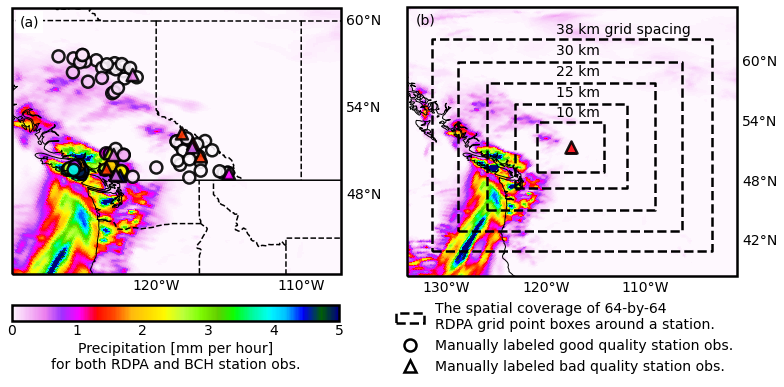

In [16]:
labels = ['10 km', '15 km', '22 km', '30 km', '38 km grid spacing'][::-1]
# ----- #
vmin = 0.0
vmax = 5

fig = plt.figure(figsize=(13, 6))
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
AX = [ax1, ax2]

# ===== #
for i, ax in enumerate(AX):
    if i == 0:
        edge = edge1
    else:
        edge = edge2
        
    ax.set_extent(edge, ccrs.Geodetic())
    ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor=cmap_pct(0))
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), zorder=4)
    if i == 0:
        ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='-', linewidth=1.5, zorder=3)
        ax.add_feature(PROVINCE, edgecolor='k', linestyle='--', linewidth=1.5, zorder=3)
    ax.spines['geo'].set_linewidth(2.5)
    
    GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0)
    GL.top_labels = False
    GL.left_labels = False
    GL.xformatter = LONGITUDE_FORMATTER
    GL.yformatter = LATITUDE_FORMATTER
    GL.xlabel_style = {'size': 14}
    GL.ylabel_style = {'size': 14}
    GL.xlocator = mticker.FixedLocator([-140, -130, -120, -110, -100])
    GL.ylocator = mticker.FixedLocator([36, 42, 48, 54, 60])

CS = ax1.pcolormesh(capa_lon, capa_lat, CaPA, vmin=vmin, vmax=vmax, cmap=cmap_pct)
ax1.scatter(stn_lon[stn_flag][~flag_nz], stn_lat[stn_flag][~flag_nz], c=stn_obs_raw[~flag_nz], s=12*12, 
            edgecolor='k', linewidth=2.5, zorder=4, vmin=vmin, vmax=vmax, cmap=cmap_pct, alpha=0.9)
ax1.scatter(stn_lon[stn_flag][flag_nz], stn_lat[stn_flag][flag_nz], c=stn_obs_raw[flag_nz], marker='^', s=12*12, 
            edgecolor='k', linewidth=2.5, zorder=5, vmin=vmin, vmax=vmax, cmap=cmap_pct, alpha=0.9)

handle_text = ax1.text(0.025, 0.975, '(a)', ha='left', va='top', fontsize=14, transform=ax1.transAxes, zorder=6)
handle_text.set_bbox(dict(facecolor='w', edgecolor='none', zorder=6))

handle_text = ax2.text(0.025, 0.975, '(b)', ha='left', va='top', fontsize=14, transform=ax2.transAxes, zorder=6)
handle_text.set_bbox(dict(facecolor='none', edgecolor='none', zorder=6))

boxes = []; legend_box = []
ax2.pcolormesh(capa_lon, capa_lat, CaPA, vmin=vmin, vmax=vmax, cmap=cmap_pct)

ax2.scatter(stn_lon[stn_flag][flag_3][0], stn_lat[stn_flag][flag_3][0], c=stn_obs_raw[flag_3][0], 
            marker='^', s=12*12, edgecolor='k', linewidth=2.5, zorder=5, vmin=vmin, vmax=vmax, 
            cmap=cmap_pct, alpha=0.9)

for i in range(5):
    points = np.array([[EDGE_x[i][0, stn_ind], EDGE_y[i][0, stn_ind]],
                       [EDGE_x[i][1, stn_ind], EDGE_y[i][1, stn_ind]],
                       [EDGE_x[i][2, stn_ind], EDGE_y[i][2, stn_ind]],
                       [EDGE_x[i][3, stn_ind], EDGE_y[i][3, stn_ind]]])
    
    boxes = PatchCollection([patches.Polygon(points)], facecolor='none', edgecolor='k',
                            linewidth=2.5, linestyle='--', zorder=5)
    ax2.add_collection(boxes)

legend_box.append(
    patches.Patch(
        facecolor='none', edgecolor='k', linewidth=2.5, linestyle='--',
        label='The spatial coverage of 64-by-64\nRDPA grid point boxes around a station.'))

legend_box.append(mlines.Line2D([], [], color='w', marker='o', ms=12, mec='k', mew=2.5, 
                                label='Manually labeled good quality station obs.'))
legend_box.append(mlines.Line2D([], [], color='w', marker='^', ms=12, mec='k', mew=2.5, 
                                label='Manually labeled bad quality station obs.'))

y0 = 0.9; dy = 0.0775
for l, label in enumerate(labels):
    ax2.text(0.45, y0-l*dy, label, fontsize=14, transform=ax2.transAxes)

ax_lg = fig.add_axes([0.545, -0.04, 0.365, 0.2])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=legend_box, bbox_to_anchor=(1, 1), ncol=1, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

ax_base = fig.add_axes([0.125, 0.0, 0.35, 0.125])
[j.set_linewidth(0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='30%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='horizontal', cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.set_label('Precipitation [mm per hour]\nfor both RDPA and BCH station obs.', fontsize=14)
CBar.outline.set_linewidth(2.5)

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'QC_preprocess_example.png', format='png', **fig_keys)

# Create 64-by-64 CaPA frames (save to numpy)

In [17]:
# all stations
with pd.HDFStore(BACKUP_dir+'BCH_metadata.hdf', 'r') as hdf_temp:
    metadata = hdf_temp['metadata']
    stn_lon = metadata['lon'][:].values
    stn_lat = metadata['lat'][:].values
    stn_code = metadata['code'][:].values

In [18]:
ens = 5 # number of ensemble classifiers

grid_stn = {}

for i, code in enumerate(stn_code):
    DATA = np.empty([ens*2, half_edge[0]*2, half_edge[1]*2])
    for j in range(ens):
        temp_indx = inds_x[j][i]
        temp_indy = inds_y[j][i]

        temp_xgrid = xgrid[j][temp_indx-half_edge[0]:temp_indx+half_edge[0], 
                              temp_indy-half_edge[1]:temp_indy+half_edge[1]]
        temp_ygrid = ygrid[j][temp_indx-half_edge[0]:temp_indx+half_edge[0], 
                              temp_indy-half_edge[1]:temp_indy+half_edge[1]]
        DATA[2*j, ...] = temp_xgrid
        DATA[2*j+1, ...] = temp_ygrid

    grid_stn[code] = DATA

In [19]:
# np.save(BACKUP_dir+'station_latlon_64.npy', grid_stn)